# Desharnais

In [38]:
from libs.data.Db import Db
import pandas as pd

dataset = "desharnais"

db = Db().getDb()
coll = db[dataset]

cat_data = pd.DataFrame(
    list(coll.find({}, { 'Language': 1, '_id': 0 }))
)
nom_data = pd.DataFrame(
    list(coll.find({}, { 'TeamExp': 1, 'ManagerExp': 1, 'Length': 1, 'Transactions': 1, 'Entities': 1,
                         'PointsNonAdjust': 1, 'Envergure': 1, 'PointsAdjust': 1, '_id': 0 }))
)
unprocessed_data = pd.DataFrame(
    list(coll.find({}, { 'id': 1, 'Project': 1, 'Effort': 1, '_id': 0 }))
)

time: 53.2 ms


## OneHotEncoding

In [39]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd

if 'Language' in cat_data.columns:
    ct = ColumnTransformer([(
        "ohe",
        OneHotEncoder(categories='auto', sparse=False),
        ["Language"]
    )])
    encoded_data = ct.fit_transform(cat_data)
    cat_data = pd.DataFrame()
    cat_data["Is_BasicCobol"] = encoded_data[:,0]
    cat_data["Is_AdvancedCobol"] = encoded_data[:,1]
    cat_data["Is_4GL"] = encoded_data[:,2]
    
nom_data = pd.concat([nom_data, cat_data], axis='columns')

time: 27.4 ms


## Unvollständige Daten

In [40]:
nom_data = nom_data[nom_data["TeamExp"] != "?"]
nom_data = nom_data[nom_data["ManagerExp"] != "?"]

time: 8.11 ms


## Normalisierung

In [41]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

for col in nom_data.columns:
    if nom_data[col].dtype == 'int' or nom_data[col].dtype == 'object':
        nom_data[col] = nom_data[col].astype('float')

scaler = StandardScaler()
scaled_data = scaler.fit_transform(nom_data)
scaled_data = pd.DataFrame(scaled_data, columns=nom_data.columns)

whole_data = pd.concat([unprocessed_data, scaled_data], axis='columns')

time: 421 ms


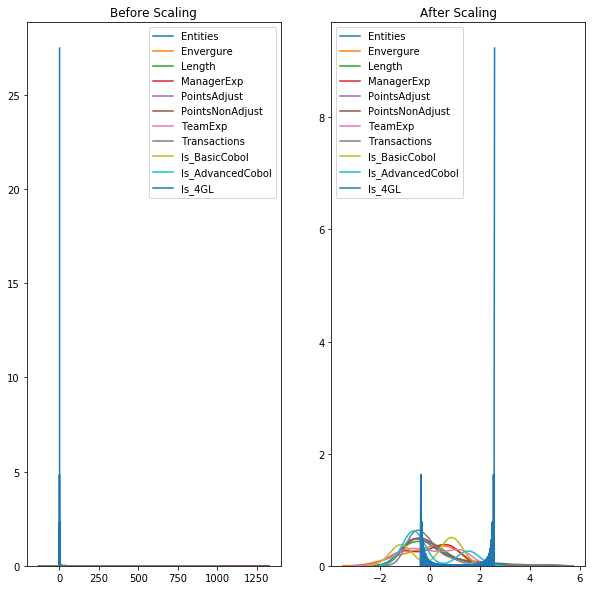

time: 1.62 s


In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 10))

ax1.set_title('Before Scaling')
for col in nom_data.columns:
    sns.kdeplot(nom_data[col], ax=ax1)
ax2.set_title('After Scaling')
for col in scaled_data.columns:
    sns.kdeplot(scaled_data[col], ax=ax2)
plt.show()

## Speichern

In [43]:
whole_data = whole_data.dropna() # NaN's appeared for removed projects due to incompleteness

dataset_pre = "{}_pre".format(dataset)
coll_pre = db[dataset_pre]
coll_pre.delete_many({})
coll_pre.insert_many(whole_data.to_dict('records'))

time: 42.5 ms


# Maxwell

In [7]:
from libs.data.Db import Db
import pandas as pd

dataset = "maxwell"

db = Db().getDb()
coll = db[dataset]

cat_data = pd.DataFrame(
    list(coll.find({}, { 'App': 1, 'Har': 1, 'Dba': 1, 'T01': 1, 'T02': 1, 'T03': 1, 'T04': 1, 'T05': 1, 'T06': 1, 
                         'T07': 1, 'T08': 1, 'T09': 1, 'T10': 1, 'T11': 1, 'T12': 1, 'T13': 1, 'T14': 1, 'T15': 1,
                         '_id': 0 }))
)
nom_data = pd.DataFrame(
    list(coll.find({}, { 'Nlan': 1, 
                         'Time': 1, 'Size': 1, 'Duration': 1, '_id': 0 }))
)
unprocessed_data = pd.DataFrame(
    list(coll.find({}, { 'Telonuse': 1, 'Ifc': 1, 'Source': 1, 'Effort': 1, '_id': 0 }))
)

time: 53.6 ms


## OneHotEncoding

In [8]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd

def onehotencoding(col, new_cols, categories="auto"):
    cats = pd.DataFrame()
    if col in cat_data.columns:
        ct = ColumnTransformer([(
            "ohe",
            OneHotEncoder(categories=categories, sparse=False),
            [col]
        )])
        encoded_data = ct.fit_transform(cat_data)
        for i, new_col in enumerate(new_cols):
            cats[new_col] = encoded_data[:,i]
    return cats

new_cat_data = pd.DataFrame()
new_cat_data = pd.concat([new_cat_data, onehotencoding("App", ["Is_CS", "Is_MIS", "Is_TCLOP", "Is_PCLOP", "Is_IS"])], axis='columns')
new_cat_data = pd.concat([new_cat_data, onehotencoding("Har", ["Is_Network", "Is_Mainframe", "Is_PC", "Is_MiniComputer", "Is_MultiPlatform"])], axis='columns')
new_cat_data = pd.concat([new_cat_data, onehotencoding("Dba", ["Is_NoDba", "Is_Relational", "Is_OtherDba", "Is_Sequential"])], axis='columns')
for i in range(1,16):
    col = "T0{}".format(i) if i < 10 else "T{}".format(i)
    new_cols = ["Is_{}_VeryLow".format(col), "Is_{}_Low".format(col), "Is_{}_Nominal".format(col), "Is_{}_High".format(col), "Is_{}_VeryHigh".format(col)]
    new_cat_data = pd.concat([new_cat_data, onehotencoding(col, new_cols, [range(1,6)])], axis='columns')

nom_data = pd.concat([nom_data, new_cat_data], axis='columns')

time: 274 ms


## Normalisierung

In [9]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

for col in nom_data.columns:
    if nom_data[col].dtype == 'int' or nom_data[col].dtype == 'object':
        nom_data[col] = nom_data[col].astype('float')

scaler = StandardScaler()
scaled_data = scaler.fit_transform(nom_data)
scaled_data = pd.DataFrame(scaled_data, columns=nom_data.columns)

whole_data = pd.concat([unprocessed_data, scaled_data], axis='columns')

time: 32.4 ms


/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


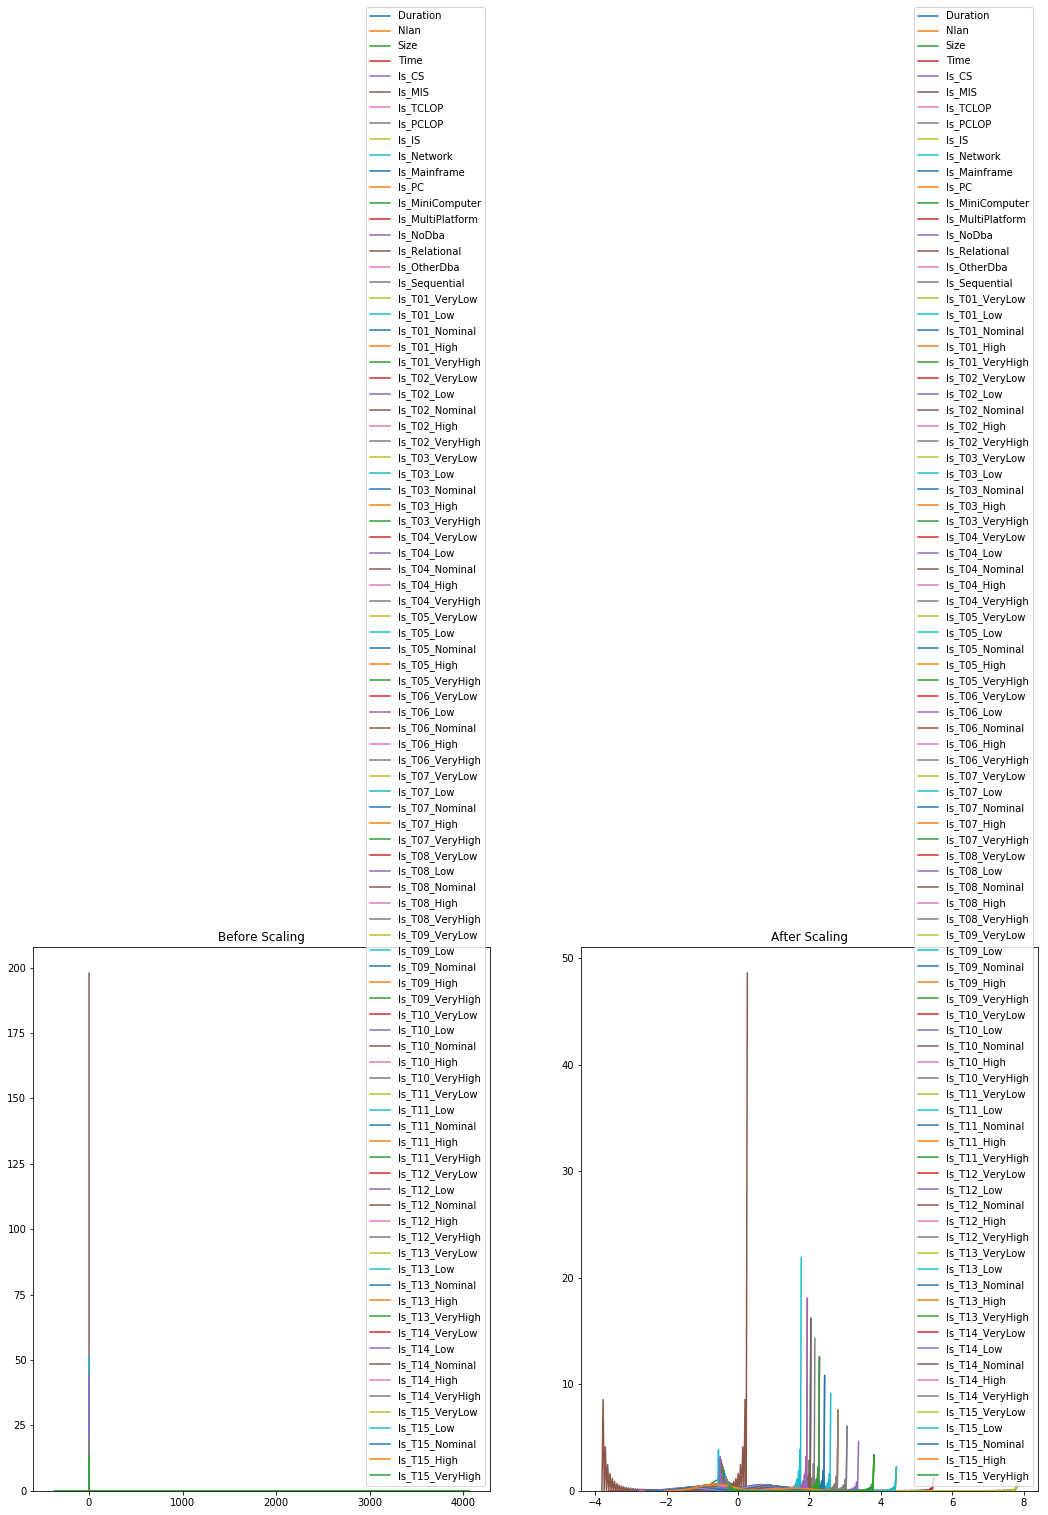

time: 22.2 s


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 10))

ax1.set_title('Before Scaling')
for col in nom_data.columns:
    sns.kdeplot(nom_data[col], ax=ax1)
ax2.set_title('After Scaling')
for col in scaled_data.columns:
    sns.kdeplot(scaled_data[col], ax=ax2)
plt.show()

## Speichern

In [11]:
dataset_pre = "{}_pre".format(dataset)
coll_pre = db[dataset_pre]
coll_pre.delete_many({})
coll_pre.insert_many(whole_data.to_dict('records'))

time: 967 ms


# Albrecht

In [12]:
from libs.data.Db import Db
import pandas as pd

dataset = "albrecht"

db = Db().getDb()
coll = db[dataset]

nom_data = pd.DataFrame(
    list(coll.find({}, { 'Input': 1, 'Output': 1, 'Inquiry': 1, 'File': 1, 'FPAdj': 1, 'RawFPcounts': 1, 'AdjFP': 1, '_id': 0 }))
)
unprocessed_data = pd.DataFrame(
    list(coll.find({}, { 'Effort': 1, '_id': 0 }))
)

time: 45.3 ms


## Normalisierung

In [13]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

for col in nom_data.columns:
    if nom_data[col].dtype == 'int' or nom_data[col].dtype == 'object':
        nom_data[col] = nom_data[col].astype('float')

scaler = StandardScaler()
scaled_data = scaler.fit_transform(nom_data)
scaled_data = pd.DataFrame(scaled_data, columns=nom_data.columns)

whole_data = pd.concat([unprocessed_data, scaled_data], axis='columns')

time: 22.1 ms


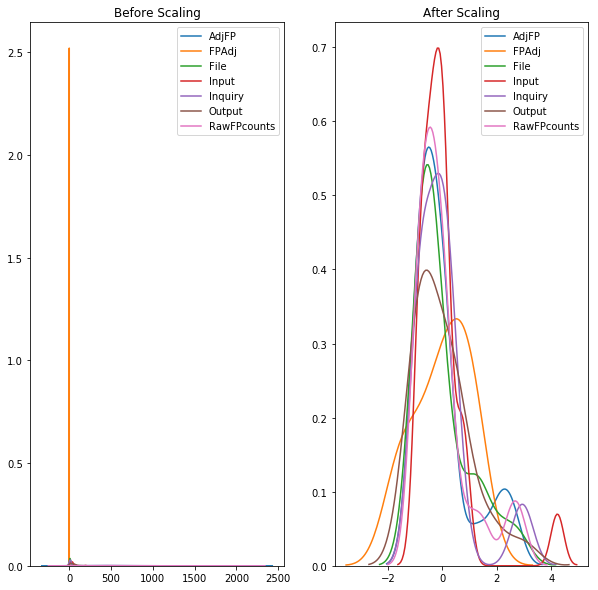

time: 1.27 s


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 10))

ax1.set_title('Before Scaling')
for col in nom_data.columns:
    sns.kdeplot(nom_data[col], ax=ax1)
ax2.set_title('After Scaling')
for col in scaled_data.columns:
    sns.kdeplot(scaled_data[col], ax=ax2)
plt.show()

## Speichern

In [15]:
dataset_pre = "{}_pre".format(dataset)
coll_pre = db[dataset_pre]
coll_pre.delete_many({})
coll_pre.insert_many(whole_data.to_dict('records'))

time: 1.02 s


# Miyazaki94

In [16]:
from libs.data.Db import Db
import pandas as pd

dataset = "miyazaki94"

db = Db().getDb()
coll = db[dataset]

nom_data = pd.DataFrame(
    list(coll.find({}, { 'KLOC': 1, 'SCRN': 1, 'FORM': 1, 'FILE': 1, 'ESCRN': 1, 'EFORM': 1, 'EFILE': 1, '_id': 0 }))
)
unprocessed_data = pd.DataFrame(
    list(coll.find({}, { 'MM': 1, 'ID': 1, '_id': 0 }))
)

time: 36.4 ms


## Normalisierung

In [17]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

for col in nom_data.columns:
    if nom_data[col].dtype == 'int' or nom_data[col].dtype == 'object':
        nom_data[col] = nom_data[col].astype('float')

scaler = StandardScaler()
scaled_data = scaler.fit_transform(nom_data)
scaled_data = pd.DataFrame(scaled_data, columns=nom_data.columns)

whole_data = pd.concat([unprocessed_data, scaled_data], axis='columns')

time: 22.3 ms


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 10))

ax1.set_title('Before Scaling')
for col in nom_data.columns:
    sns.kdeplot(nom_data[col], ax=ax1)
ax2.set_title('After Scaling')
for col in scaled_data.columns:
    sns.kdeplot(scaled_data[col], ax=ax2)
plt.show()

time: 1.54 s


## Speichern

In [19]:
dataset_pre = "{}_pre".format(dataset)
coll_pre = db[dataset_pre]
coll_pre.delete_many({})
coll_pre.insert_many(whole_data.to_dict('records'))

time: 1.08 s


# Kemerer

In [20]:
from libs.data.Db import Db
import pandas as pd

dataset = "kemerer"

db = Db().getDb()
coll = db[dataset]

cat_data = pd.DataFrame(
    list(coll.find({}, { 'Language': 1, 'Hardware': 1, '_id': 0 }))
)
nom_data = pd.DataFrame(
    list(coll.find({}, { 'KSLOC': 1, 'Duration': 1, 'AdjFP': 1, 'RAWFP': 1, '_id': 0 }))
)
unprocessed_data = pd.DataFrame(
    list(coll.find({}, { 'EffortMM': 1, 'ID': 1, '_id': 0 }))
)

time: 42.9 ms


## OneHotEncoding

In [21]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd

new_cat_data = pd.DataFrame()

if 'Language' in cat_data.columns:
    ct = ColumnTransformer([(
        "ohe",
        OneHotEncoder(categories='auto', sparse=False),
        ["Language"]
    )])
    encoded_data = ct.fit_transform(cat_data)
    cats = pd.DataFrame()
    cats["Is_Language1"] = encoded_data[:,0]
    cats["Is_Language2"] = encoded_data[:,1]
    cats["Is_Language3"] = encoded_data[:,2]
    new_cat_data = pd.concat([new_cat_data, cats], axis='columns')
    
if 'Hardware' in cat_data.columns:
    ct = ColumnTransformer([(
        "ohe",
        OneHotEncoder(categories='auto', sparse=False),
        ["Hardware"]
    )])
    encoded_data = ct.fit_transform(cat_data)
    cats = pd.DataFrame()
    cats["Is_Hardware1"] = encoded_data[:,0]
    cats["Is_Hardware2"] = encoded_data[:,1]
    cats["Is_Hardware3"] = encoded_data[:,2]
    cats["Is_Hardware4"] = encoded_data[:,3]
    cats["Is_Hardware5"] = encoded_data[:,4]
    cats["Is_Hardware6"] = encoded_data[:,5]
    new_cat_data = pd.concat([new_cat_data, cats], axis='columns')
    
nom_data = pd.concat([nom_data, new_cat_data], axis='columns')

time: 61.1 ms


## Normalisierung

In [22]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

for col in nom_data.columns:
    if nom_data[col].dtype == 'int' or nom_data[col].dtype == 'object':
        nom_data[col] = nom_data[col].astype('float')

scaler = StandardScaler()
scaled_data = scaler.fit_transform(nom_data)
scaled_data = pd.DataFrame(scaled_data, columns=nom_data.columns)

whole_data = pd.concat([unprocessed_data, scaled_data], axis='columns')

time: 34.1 ms


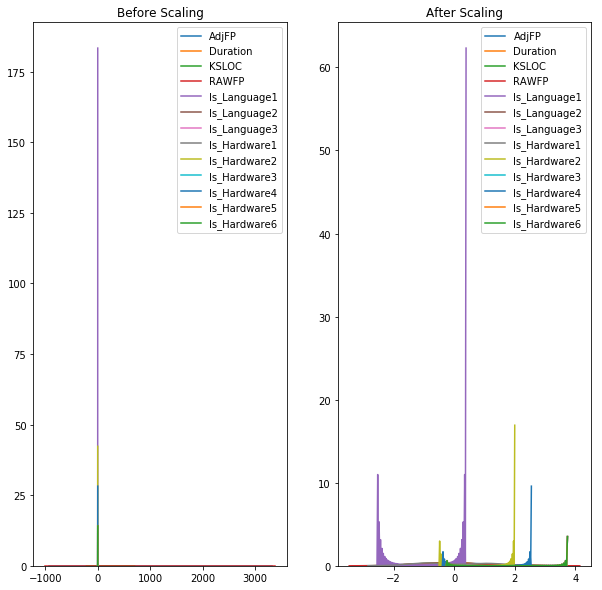

time: 1.59 s


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 10))

ax1.set_title('Before Scaling')
for col in nom_data.columns:
    sns.kdeplot(nom_data[col], ax=ax1)
ax2.set_title('After Scaling')
for col in scaled_data.columns:
    sns.kdeplot(scaled_data[col], ax=ax2)
plt.show()

## Speichern

In [24]:
dataset_pre = "{}_pre".format(dataset)
coll_pre = db[dataset_pre]
coll_pre.delete_many({})
coll_pre.insert_many(whole_data.to_dict('records'))

time: 1.06 s


# CocomoNasaV1

In [25]:
from libs.data.Db import Db
import pandas as pd

dataset = "cocomonasav1"

db = Db().getDb()
coll = db[dataset]

labeled_data = pd.DataFrame(
    list(coll.find({}, { 'RELY': 1, 'DATA': 1, 'CPLX': 1, 'TIME': 1, 'STOR': 1, 'VIRT': 1, 
                         'TURN': 1, 'ACAP': 1, 'AEXP': 1, 'PCAP': 1, 'VEXP': 1, 'LEXP': 1,
                         'MODP': 1, 'TOOL': 1, 'SCED': 1, '_id': 0 }))
)
nom_data = pd.DataFrame(
    list(coll.find({}, { 'LOC': 1, '_id': 0 }))
)
unprocessed_data = pd.DataFrame(
    list(coll.find({}, { 'ACT_EFFORT': 1, 'id': 1, '_id': 0 }))
)

time: 50.8 ms


## LabelEncoding

In [26]:
cat_data = labeled_data.replace(
    ["Very_Low", "Low", "Nominal", "High", "Very_High", "Extra_High"],
    [1, 2, 3, 4, 5, 6]
)

time: 13.7 ms


## OneHotEncoding

In [27]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd

def onehotencoding(col, new_cols, categories="auto"):
    cats = pd.DataFrame()
    if col in cat_data.columns:
        ct = ColumnTransformer([(
            "ohe",
            OneHotEncoder(categories=categories, sparse=False),
            [col]
        )])
        encoded_data = ct.fit_transform(cat_data)
        for i, new_col in enumerate(new_cols):
            cats[new_col] = encoded_data[:,i]
    return cats

new_cat_data = pd.DataFrame()
columns = ['RELY', 'DATA', 'CPLX', 'TIME', 'STOR', 'VIRT', 'TURN', 'ACAP', 
              'AEXP', 'PCAP', 'VEXP', 'LEXP', 'MODP', 'TOOL', 'SCED']
for col in columns:
    new_cols = ["Is_{}_VeryLow".format(col), "Is_{}_Low".format(col), "Is_{}_Nominal".format(col), 
                "Is_{}_High".format(col), "Is_{}_VeryHigh".format(col), "Is_{}_ExtraHigh".format(col)]
    new_cat_data = pd.concat([new_cat_data, onehotencoding(col, new_cols, [range(1,7)])], axis='columns')

nom_data = pd.concat([nom_data, new_cat_data], axis='columns')

time: 326 ms


## Normalisierung

In [28]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

for col in nom_data.columns:
    if nom_data[col].dtype == 'int' or nom_data[col].dtype == 'object':
        nom_data[col] = nom_data[col].astype('float')

scaler = StandardScaler()
scaled_data = scaler.fit_transform(nom_data)
scaled_data = pd.DataFrame(scaled_data, columns=nom_data.columns)

whole_data = pd.concat([unprocessed_data, scaled_data], axis='columns')

time: 31.2 ms


/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


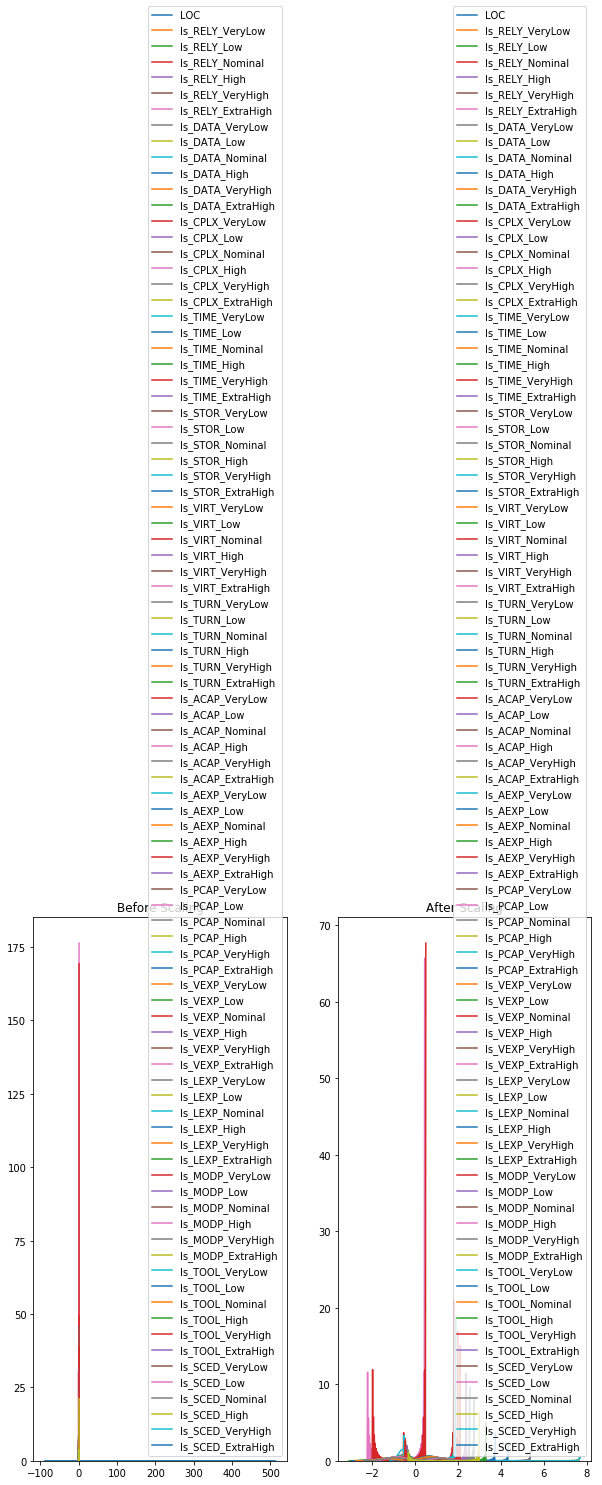

time: 20.8 s


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 10))

ax1.set_title('Before Scaling')
for col in nom_data.columns:
    sns.kdeplot(nom_data[col], ax=ax1)
ax2.set_title('After Scaling')
for col in scaled_data.columns:
    sns.kdeplot(scaled_data[col], ax=ax2)
plt.show()

## Speichern

In [30]:
dataset_pre = "{}_pre".format(dataset)
coll_pre = db[dataset_pre]
coll_pre.delete_many({})
coll_pre.insert_many(whole_data.to_dict('records'))

time: 1.27 s


# CocomoNasaV2

In [31]:
from libs.data.Db import Db
import pandas as pd

dataset = "cocomonasav2"

db = Db().getDb()
coll = db[dataset]

cat_data = pd.DataFrame(
    list(coll.find({}, { 'cat2': 1, 'forg': 1, 'center': 1, 'mode': 1, '_id': 0 }))
)
cocomo_data = pd.DataFrame(
    list(coll.find({}, { 'rely': 1, 'data': 1, 'cplx': 1, 'time': 1, 'stor': 1, 'virt': 1, 
                         'turn': 1, 'acap': 1, 'aexp': 1, 'pcap': 1, 'vexp': 1, 'lexp': 1,
                         'modp': 1, 'tool': 1, 'sced': 1, '_id': 0 }))
)
nom_data = pd.DataFrame(
    list(coll.find({}, { 'equivphyskloc': 1, '_id': 0 }))
)
unprocessed_data = pd.DataFrame(
    list(coll.find({}, { 'act_effort': 1, 'id': 1, '_id': 0 }))
)

time: 63.3 ms


## LabelEncoding

In [32]:
cat_data['cat2'].replace(['Avionics', 'application_ground', 'avionicsmonitoring', 'batchdataprocessing', 'communications', 
                          'datacapture', 'launchprocessing', 'missionplanning', 'monitor_control', 'operatingsystem', 
                          'realdataprocessing', 'science', 'simulation', 'utility'], range(14), inplace=True)
cat_data['forg'].replace(['f', 'g'], range(2), inplace=True)
# no need to encode center
cat_data['mode'].replace(['embedded', 'organic', 'semidetached'], range(3), inplace=True)

time: 25 ms


In [33]:
encoded_data = cocomo_data.replace(
    ["vl", "l", "n", "h", "vh", "xh"],
    [1, 2, 3, 4, 5, 6]
)
cat_data = pd.concat([encoded_data, cat_data], axis='columns')

time: 70.1 ms


## OneHotEncoding

In [34]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd

def onehotencoding(col, new_cols, categories="auto"):
    cats = pd.DataFrame()
    if col in cat_data.columns:
        ct = ColumnTransformer([(
            "ohe",
            OneHotEncoder(categories=categories, sparse=False),
            [col]
        )])
        
        encoded_data = ct.fit_transform(cat_data)
        for i, new_col in enumerate(new_cols):
            cats[new_col] = encoded_data[:,i]
    return cats

new_cat_data = pd.DataFrame()
new_cat_data = pd.concat([new_cat_data, onehotencoding(
    "cat2", 
    ["Is_Avionics", "Is_application_ground", "Is_avionicsmonitoring", "Is_batchdataprocessing", "Is_communications", 
     "Is_datacapture", "Is_launchprocessing", "Is_missionplanning", "Is_monitor_control", "Is_operatingsystem", 
     "Is_realdataprocessing", "Is_science", "Is_simulation", "Is_utility"],
    [range(14)]
)], axis='columns')

new_cat_data = pd.concat([new_cat_data, onehotencoding(
    "forg", 
    ["Is_Flight", "Is_Ground"],
    [range(2)]
)], axis='columns')

new_cat_data = pd.concat([new_cat_data, onehotencoding(
    "center", 
    ["Is_Center1", "Is_Center2", "Is_Center3", "Is_Center4", "Is_Center5", "Is_Center6"],
    [range(1, 7)]
)], axis='columns')

new_cat_data = pd.concat([new_cat_data, onehotencoding(
    "mode", 
    ["Is_embedded", "Is_organic", "Is_semidetached"],
    [range(3)]
)], axis='columns')

columns = ['rely', 'data', 'cplx', 'time', 'stor', 'virt', 'turn', 'acap', 
           'aexp', 'pcap', 'vexp', 'lexp', 'modp', 'tool', 'sced']
for col in columns:
    new_cols = ["Is_{}_vl".format(col), "Is_{}_l".format(col), "Is_{}_n".format(col), 
                "Is_{}_h".format(col), "Is_{}_vh".format(col), "Is_{}_eh".format(col)]
    new_cat_data = pd.concat([new_cat_data, onehotencoding(col, new_cols, [range(1,7)])], axis='columns')

nom_data = pd.concat([nom_data, new_cat_data], axis='columns')

time: 344 ms


## Normalisierung

In [35]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

for col in nom_data.columns:
    if nom_data[col].dtype == 'int' or nom_data[col].dtype == 'object':
        nom_data[col] = nom_data[col].astype('float')

scaler = StandardScaler()
scaled_data = scaler.fit_transform(nom_data)
scaled_data = pd.DataFrame(scaled_data, columns=nom_data.columns)

whole_data = pd.concat([unprocessed_data, scaled_data], axis='columns')

time: 33.9 ms


In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 10))

ax1.set_title('Before Scaling')
for col in nom_data.columns:
    sns.kdeplot(nom_data[col], ax=ax1)
ax2.set_title('After Scaling')
for col in scaled_data.columns:
    sns.kdeplot(scaled_data[col], ax=ax2)
plt.show()

/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


time: 32.4 s


## Speichern

In [37]:
dataset_pre = "{}_pre".format(dataset)
coll_pre = db[dataset_pre]
coll_pre.delete_many({})
coll_pre.insert_many(whole_data.to_dict('records'))

time: 1.23 s
